# Standardize the format of the global datasets

We have data in several formats (netCDF, csv, gdf) which can be hard to deal with. Most of our global data are grids and could be distributed as netCDF files to make the students' lives easier.

In this notebook, we'll load these datasets, clean them up and combine them (when necessary), and then export them to netCDF.

In [1]:
from pathlib import Path
import lzma
import bz2
import numpy as np
import pandas as pd
import xarray as xr
import harmonica as hm
import boule as bl
import verde as vd

In [2]:
data_dir = Path("..") / "data"

## Heat flow

Load the compilation by [Lucazeau (2019)](https://doi.org/10.1029/2019GC008389). The data are in CSV format and are pixel registered. This makes it a bit tricky to work with and the data names are also a bit difficult to grep. We'll convert this to a grid-node registered grid with the same spacing as all the rest.

In [3]:
heat_flow_table = pd.read_csv(Path("..") / "data" / "raw" / "HFgrid14.csv", sep=";")
heat_flow_table

,longitude,latitude,HF_pred,sHF_pred,Hf_obs
0,-179.75,89.75,121.0,19.9,NaN
1,-179.25,89.75,80.2,32.8,NaN
2,-178.75,89.75,81.1,44.5,NaN
3,-178.25,89.75,81.0,44.6,NaN
4,-177.75,89.75,109.1,19.0,NaN
...,...,...,...,...,...
259195,177.75,-89.75,75.4,36.5,NaN
259196,178.25,-89.75,75.4,36.5,NaN
259197,178.75,-89.75,75.4,36.5,NaN
259198,179.25,-89.75,75.2,36.8,NaN


Remove the few heat flow values that are negative for some reason. They through off the colorbar and there are only 7 of them.

In [4]:
heat_flow_table = heat_flow_table[heat_flow_table.HF_pred >= 0]

Make a grid-node registered grid by nearest-neighbor interpolation and set some of the metadata attributes

In [5]:
interpolator = vd.ScipyGridder("nearest").fit((heat_flow_table.longitude, heat_flow_table.latitude), heat_flow_table.HF_pred)
heat_flow = interpolator.grid(region=(-180, 180, -90, 90), spacing=0.2, dims=("latitude", "longitude"), data_names=["heat_flow"])
heat_flow.heat_flow.attrs["long_name"] = "Heat flow"
heat_flow.heat_flow.attrs["units"] = "mW/m²"
heat_flow.heat_flow.attrs["provenance"] = "Based on the compilation by Lucazeau (2019; https://doi.org/10.1029/2019GC008389). Converted to grid-node registration by nearest-neighbor interpolation"
heat_flow

<xarray.Dataset>
Dimensions:    (latitude: 901, longitude: 1801)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.6 ... 179.6 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.8 -89.6 -89.4 ... 89.6 89.8 90.0
Data variables:
    heat_flow  (latitude, longitude) float64 75.2 75.2 75.2 ... 84.7 84.7 84.7
Attributes:
    metadata:  Generated by ScipyGridder(method='nearest')

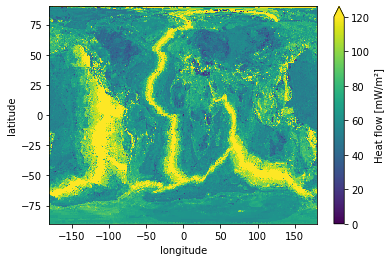

In [6]:
heat_flow.heat_flow.plot(vmin=0, vmax=120)

## Age of the oceanic lithosphere

Load in the lithospheric age grid of [Müller et al. (2008)](https://doi.org/10.1029/2007GC001743) and downsample it to 0.2 degree resolution by a block median operation.

In [7]:
with bz2.open(data_dir / "raw" / "age.3.6.nc.bz2") as grid_file:
    age_original = (xr.open_dataarray(grid_file) / 100).coarsen(x=2, y=2, boundary='trim').median()
age_original

<xarray.DataArray (y: 900, x: 1800)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [59.325   , 57.78    , 57.21    , ..., 57.965   , 57.989998,
        57.975   ],
       [57.825   , 57.8     , 57.8     , ..., 57.835   , 57.809998,
        57.78    ],
       [55.46    , 55.475   , 55.48    , ..., 55.449997, 55.455   ,
        55.46    ]], dtype=float32)
Coordinates:
  * x        (x) float32 -179.9 -179.8 -179.6 -179.4 ... 179.2 179.4 179.6 179.9
  * y        (y) float32 -89.95 -89.75 -89.55 -89.35 ... 89.25 89.45 89.65 89.85

In [8]:
age_table = vd.grid_to_table(age_original)
interpolator = vd.ScipyGridder("nearest").fit((age_table.x, age_table.y), age_table.scalars)
age = interpolator.grid(region=(-180, 180, -90, 90), spacing=0.2, dims=("latitude", "longitude"), data_names=["lithosphere_age"])
age.lithosphere_age.attrs["long_name"] = "Age of the oceanic lithosphere"
age.lithosphere_age.attrs["units"] = "million years"
age.lithosphere_age.attrs["provenance"] = "Based on Müller et al. (2008; https://doi.org/10.1029/2007GC001743). Downsampled with a block median and converted to grid-node registration by nearest-neighbor interpolation."
age

<xarray.Dataset>
Dimensions:          (latitude: 901, longitude: 1801)
Coordinates:
  * longitude        (longitude) float64 -180.0 -179.8 -179.6 ... 179.8 180.0
  * latitude         (latitude) float64 -90.0 -89.8 -89.6 ... 89.6 89.8 90.0
Data variables:
    lithosphere_age  (latitude, longitude) float32 nan nan nan ... 55.46 55.46
Attributes:
    metadata:  Generated by ScipyGridder(method='nearest')

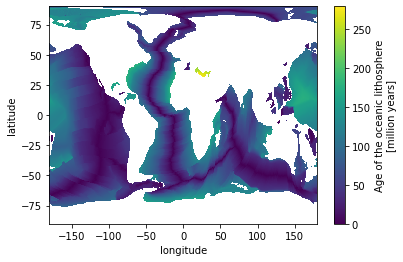

In [9]:
age.lithosphere_age.plot()

## Gravity and topography

We'll start with the gravity, topography, and geoid data from ICGEM. After loading, copy the `attrs` to the `DataArray` so that it doesn't get lost when merging all of the datasets.

In [10]:
with lzma.open(data_dir / "raw" / "EIGEN-6C4-geoid.gdf.xz", mode="rt") as file:
    geoid = hm.load_icgem_gdf(file, dtype="float32")
geoid.geoid.attrs = geoid.attrs
geoid

<xarray.Dataset>
Dimensions:    (latitude: 901, longitude: 1801)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.6 ... 179.6 179.8 180.0
  * latitude   (latitude) float32 -90.0 -89.8 -89.6 -89.4 ... 89.6 89.8 90.0
Data variables:
    geoid      (latitude, longitude) float32 -29.41 -29.41 ... 15.47 15.47
Attributes: (12/34)
    generating_institute:  gfz-potsdam
    generating_date:       2021/04/09
    product_type:          gravity_field
    body:                  earth
    modelname:             EIGEN-6C4
    max_used_degree:       2190
    ...                    ...
    maxvalue:              8.6286454E+01 meter
    minvalue:              -1.0651734E+02 meter
    signal_wrms:           3.0591586E+01 meter
    grid_format:           long_lat_value
    attributes:            longitude latitude geoid
    attributes_units:      deg. deg. meter

In [11]:
with lzma.open(data_dir / "raw" / "EIGEN-6C4-gravity.gdf.xz", mode="rt") as file:
    gravity = hm.load_icgem_gdf(file, dtype="float32").rename(
        {"h_over_geoid": "height", "gravity_earth": "gravity"}
    )
gravity.gravity.attrs = gravity.attrs

In [12]:
with lzma.open(data_dir / "raw" / "etopo1.gdf.xz", mode="rt") as file:
    topography = hm.load_icgem_gdf(file, dtype="float32").rename(
        {"topography_grd": "topography"}
    )
topography.topography.attrs = topography.attrs

In [13]:
with lzma.open(data_dir / "raw" / "etopo1-filtered.gdf.xz", mode="rt") as file:
    topography_smooth = hm.load_icgem_gdf(file, dtype="float32").rename(
        {"topography_shm": "topography"}
    )
topography_smooth.topography.attrs = topography_smooth.attrs

Convert all heights to geometric by subtracting the geoid height.

In [14]:
gravity["height"] += geoid.geoid
topography["topography"] += geoid.geoid
topography_smooth["topography"] += geoid.geoid

Calculate the gravity disturbance.

In [15]:
disturbance = gravity.gravity - bl.WGS84.normal_gravity(gravity.latitude, gravity.height)
disturbance.attrs = gravity.attrs

In [16]:
bouguer = disturbance - hm.bouguer_correction(topography.topography)
bouguer.attrs = gravity.attrs

## Merge all grids into one

Merge all of the grids into one so we can save a single file. Assign the height as a coordinate array in the merged grid and remove the redundant data point at 180 longitude.

In [17]:
grid = xr.merge([
    disturbance.to_dataset(name="gravity_disturbance"),
    bouguer.to_dataset(name="gravity_bouguer"),
    topography_smooth.topography.to_dataset(name="topography_smoothed"),
    topography.topography.to_dataset(name="topography"),
    heat_flow,
    age,
], join="override").assign_coords(height=gravity.height).isel(longitude=slice(0, gravity.longitude.size - 1)).astype("float32")
grid

<xarray.Dataset>
Dimensions:              (latitude: 901, longitude: 1800)
Coordinates:
  * latitude             (latitude) float32 -90.0 -89.8 -89.6 ... 89.6 89.8 90.0
  * longitude            (longitude) float32 -180.0 -179.8 ... 179.6 179.8
    height               (latitude, longitude) float32 2.716e+03 ... 15.47
Data variables:
    gravity_disturbance  (latitude, longitude) float32 -27.21 -27.21 ... 24.71
    gravity_bouguer      (latitude, longitude) float32 -331.2 -331.2 ... 312.6
    topography_smoothed  (latitude, longitude) float32 2.796e+03 ... -3.56e+03
    topography           (latitude, longitude) float32 2.716e+03 ... -4.213e+03
    heat_flow            (latitude, longitude) float32 75.2 75.2 ... 84.7 84.7
    lithosphere_age      (latitude, longitude) float32 nan nan ... 55.46 55.46

Export to netCDF using the netcdf4 engine which results in smaller files.

In [18]:
grid.to_netcdf(
    data_dir / "global-geophysical-data.nc", 
    format="NETCDF4", 
    engine="netcdf4",
)